<a href="https://colab.research.google.com/github/josh-millar/josh-millar/blob/main/jnm_diss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pre-processing functions:

Build a dataloader for the midi/wav pairs

In [2]:
!pip install pypianoroll
!pip install pretty_midi
#!tar -xf '/content/drive/MyDrive/groove/train.tar' -C '/content/drive/MyDrive/groove/'
#!tar -xf '/content/drive/MyDrive/groove/test.tar' -C '/content/drive/MyDrive/groove/'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 6.6 MB/s eta 0:00:00
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=5241449ef6588a6027c282cbff9db6d1f8c55c52e57490f0c4a78f0539e5d57e
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty-midi


create a custom data loader

In [3]:
import torch
from torch.utils.data import Dataset
import glob
import os
import pypianoroll
import numpy as np
import librosa

class ADTDataset(Dataset):
    def __init__(self, drums_directory, output_sr, n_fft, hop_size, n_bins, f_min, train=True, transform=None, target_transform=None):
        self.drums_directory = drums_directory
        self.transform = transform
        self.output_sr = output_sr
        self.n_fft = n_fft
        self.hop_size = hop_size
        self.n_bins = n_bins
        self.f_min = f_min
        self.target_transform = target_transform
        self.train = train
        # map to a reduced number of hits per https://magenta.tensorflow.org/datasets/groove
        self.mapping_dict = {0: [36], # kick
                1: [38, 40, 37], # snare
                2: [48, 50], # hi tom
                3: [45, 47], # low-mid tom
                4: [43, 58], # high floor tom
                5: [46, 26], # open hh
                6: [42, 22, 44], # closed hh
                7: [49, 55, 57, 52], # crash
                8: [51, 59, 53] # ride
                }
        if self.train:
            drums_directory = os.path.join(self.drums_directory, "train")
        else:
            drums_directory = os.path.join(self.drums_directory, "test")
        self.audio_list = sorted(glob.glob(os.path.join(drums_directory, 'audio_*.npy')))
        self.midi_list = sorted(glob.glob(os.path.join(drums_directory, 'midi_*.npy')))
        assert len(self.audio_list) == len(self.midi_list)

    def __getitem__(self, n):
        """ Loads the nth sample from the dataset """
        # conver the midi file into a binary pianoroll format
        midi_file = self.midi_list[n]
        # mid = pypianoroll.read(midi_file)
        # get the piano roll, reduce to 9-note definition
        midi_piano_roll = np.load(midi_file)
        activations = np.zeros((9))
        for hit, notes in self.mapping_dict.items():
            for note in notes:
                activations[hit] += midi_piano_roll[note]
        # if two if the same note, need to only have one:
        activations = np.clip(activations, 0, 1)
        audio_file = self.audio_list[n]
        log_mel_S = np.load(audio_file)
        # audio, sr = librosa.load(audio_file, sr=None)
        # audio_resampled = self.resample_audio(audio, sr, self.output_sr)
        # log_mel_S, log_onsets, _ = self.get_inputs(audio_resampled, n_fft, hop_size, n_bins, f_min, output_sr)

        return np.float32(log_mel_S), np.float32(activations)
        # return {
        #     "audio": audio_resampled,
        #     "sr": sr,
        #     "log_mel_S": log_mel_S,
        #     "log_onsets": log_onsets,
        #     "activations": activations,
        #     }

    def resample_audio(self, audio, sr, output_sr):
        """ resample and normalize audio"""
        audio_resampled = librosa.resample(audio, orig_sr=sr, target_sr=output_sr)
        peak_value = np.max(np.abs(audio_resampled))
        normalized_audio = audio_resampled / peak_value

        return normalized_audio

    def get_inputs(self, audio, n_fft, hop_size, n_bins, f_min, sr):
        # logf-stft:
        stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_size)
        S = np.abs(stft)
        # group the linear bins into log-spaced bins
        f_max = sr / 2
        filter_bank = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_bins, fmin=f_min, fmax=f_max)
        mel_S = np.dot(filter_bank, S)
        log_mel_S = librosa.power_to_db(mel_S)

        # logf-onset: get onsets by compute difference function between current frame
        # and previous 22 frames
        n_previous_frames = 22
        onsets = np.zeros_like(mel_S)

        for frame in range(mel_S.shape[1]):
            if frame > n_previous_frames:
                avg = np.mean(mel_S[:, frame-n_previous_frames:frame], axis=1)
                onsets[:, frame] = mel_S[:, frame] - avg
        # apply half-wave rectification by removing negative values
        onsets = np.max([np.zeros_like(onsets), onsets], axis=0)
        log_onsets = librosa.power_to_db(onsets)

        # concat
        inputs = np.stack([log_mel_S, log_onsets])
        return log_mel_S, log_onsets, inputs

    def __len__(self):
        return len(self.audio_list)




Test dataloader

In [4]:

path = '/content/drive/MyDrive/groove'

output_sr = 16000 # try 16k
n_fft = 1024
hop_size = 441
n_bins = 32
f_min = 40

# atdds = ADTDataset(path, output_sr, n_fft, hop_size, n_bins, f_min, train=False)
# input_output_dict = atdds[55]

# import matplotlib.pyplot as plt
# from IPython.display import Audio, display

# def plot_spectrogram(S):
#     plt.figure(figsize=(10, 6))
#     plt.imshow(S, aspect='auto', origin='lower', cmap='viridis')
#     plt.colorbar(format='%+2.0f dB')
#     plt.title('Log Mel Spectrogram')
#     plt.xlabel('Frames')
#     plt.ylabel('Bins')
#     plt.tight_layout()
#     plt.show()

# # display(Audio(data=input_output_dict["audio"], rate=output_sr))
# # plot_spectrogram(input_output_dict["activations"])
# # plot_spectrogram(input_output_dict["log_onsets"])
# print(input_output_dict["activations"].shape)
# print(input_output_dict["log_mel_S"].shape)

In [5]:
from torch import nn

class CNNBlock(nn.Module):
    def __init__(self):
        super(CNNBlock, self).__init__()
        self.cnn32_1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.cnn32_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.dropout30 = nn.Dropout(p=0.3)
        self.cnn64_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.cnn64_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.cnnsquash = nn.Conv2d(64, 64, kernel_size=(64,64), padding=0)
        self.bn64 = nn.BatchNorm2d(64)
        self.flatten = nn.Flatten()
        self.linear = nn.LazyLinear(9)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)
        # print("input size ", x.size())
        out = self.cnn32_1(x)
        # print("after first cnn:", out.size())
        out = self.cnn32_2(out)
        # print("after second cnn: ", out.size())
        out = self.bn32(out)
        out = self.relu(out)
        out = self.dropout30(out)
        out = self.cnn64_1(out)
        # print("after first 64 cnn:", out.size())
        out = self.cnn64_2(out)
        # print("after second 64 cnn:", out.size())
        out = self.bn64(out)
        out = self.relu(out)
        out = self.dropout30(out)
        # out = self.cnnsquash(out)
        # print("after first squash cnn:", out.size())
        out = self.bn64(out)
        out = self.relu(out)
        out = self.flatten(out)
        out = self.linear(out)
        out = self.sigmoid(out)
        # print("at output:", out.size())
        return out


In [5]:
train_set = torch.utils.data.DataLoader(ADTDataset(path, output_sr, n_fft, hop_size, n_bins, f_min, train=True))
test_set = torch.utils.data.DataLoader(ADTDataset(path, output_sr, n_fft, hop_size, n_bins, f_min, train=False))

In [6]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 7.7 MB/s eta 0:00:00


In [10]:
import my_utils as mu
from torchmetrics import F1Score, Accuracy, AveragePrecision

num_classes = 9

val_metrics = {
    'f1': F1Score(task='multilabel', num_labels=num_classes).to(device),
    'avg_precision': AveragePrecision(task='multilabel', num_labels=num_classes).to(device),
    'accuracy' : Accuracy(task='multilabel', num_labels=num_classes, top_k=1).to(device),
}

def train(net, train_iter, test_iter, loss, num_epochs, optimizer, device):
    """Training script taken mostly from lab 8"""
    net.to(device)
    animator = mu.d2l.Animator(xlabel='Epoch', xlim=[0, num_epochs], legend=['Train loss', 'Train acc', 'Test acc'])
    timer = mu.d2l.Timer()
    for epoch in range(num_epochs):
        metric = mu.d2l.Accumulator(3)
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            # print(y)
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            # print(y_hat)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            result = {}
            with torch.no_grad():
                for k in val_metrics:
                    y = y.long()
                    result[k] = val_metrics[k](y_hat, y)
                    val_metrics[k].reset()
            metric.add(result['f1'], result['avg_precision'], result['accuracy'])
            timer.stop()
            train_loss, train_acc = l.cpu().detach().numpy(), metric[1]
            if (i+1) %10 == 0:
                animator.add(epoch + i/len(train_iter), (train_loss, train_acc, None))
        # test_acc = mu.evaluate_accuracy_gpu(net, test_iter)
        net.eval()
        test_result = {}
        for _, (X_test, y_test) in enumerate(test_iter):
            X_test, y_test = X_test.to(device), y_test.to(device)
            for k in val_metrics:
                y_test = y_test.long()
                test_result[k] = val_metrics[k](net(X_test), y_test)
                val_metrics[k].reset()
        test_acc = test_result['accuracy'].cpu().detach().numpy()
        animator.add(epoch+1, (None, None, test_acc))
    f1_score = result["f1"]
    train_loss = l*X.shape[0]
    train_acc = result['accuracy']
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, train f1 {f1_score:.3f}')
    # print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
    #       f'on {str(device)}')

KeyboardInterrupt: ignored

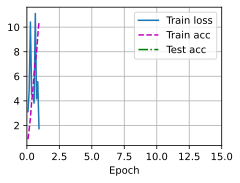

In [12]:
num_epochs = 15
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)
batch_size = 32
train_set = torch.utils.data.DataLoader(ADTDataset(path, output_sr, n_fft, hop_size, n_bins, f_min, train=True), batch_size)
test_set = torch.utils.data.DataLoader(ADTDataset(path, output_sr, n_fft, hop_size, n_bins, f_min, train=False), batch_size)
# train_set = (train_set["log_mel_S"], train_set["activations"])
# test_set = (test_set["log_mel_S"], test_set["activations"])
net = CNNBlock()
loss = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
train(net, train_set, test_set, loss, num_epochs, optimizer, device)


In [11]:
test_it = iter(test_set)
x, y = next(test_it)
x, y = x.to(device), y.to(device)
print(y)
y_pred = net(x)
print(y_pred)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
tensor([[-2.2587e+00, -5.0540e+00, -7.6235e+00,  ...,  3.6729e-02,
         -2.6532e+00, -5.0412e-01],
        [-2.2791e+00,  6.3350e-01,  1.7305e+00,  ..., -1.1163e+00,
         -4.5744e+00, -1.6431e+00],
        [-7.3612e-03, -1.4623e-01, -9.4500e-02,  ..., -1.4237e-01,
         -1.9954e-01, -6.3432e-02],
        ...,
        [-1.6557e-01, -2.6957e-01,  1.0600e-01,  ..., -4.7498e-01,
         -3.1842e-01, -5.2302e-01],
        [ 2.5731e-02, -2.5371e-02,  1.1052e-01,  ..., -4.8689e-01,
         -2.2863e-01, -3.3713e-01],
        [-1.0403e-01, -1.5044e-01,  1.1916e-01,  ..., -5.8175e-01,
         -2.6774e-01, -5.2740e-01]], device='cuda:0', grad_fn=<AddmmBackward0>)
